## Questions

In [1]:
import sys
sys.path.append('..')

import cv2

import numpy as np
import matplotlib.pyplot as plt
from src.classical_tracker import ClassicalTracker
import importlib
import src.deep_tracker
importlib.reload(src.deep_tracker)
from src.deep_tracker import DeepTracker
import torch

VIDEO_PATH_MUG = '../Test-Videos/Antoine_Mug.mp4'
VIDEO_PATH_BALL='../Test-Videos/VOT-ball.mp4'
device = 'cuda' if torch.cuda.is_available() else 'cpu'


### 1. Meanshift


**Q1: Basic Mean-shift Tracking**

Algorithm: Mean-shift on Hue channel
- Builds color histogram model from ROI
- Uses back-projection for similarity matching
- Iteratively shifts window to density maximum

In [2]:
tracker = ClassicalTracker(
    video_path=VIDEO_PATH_MUG,
    method='meanshift',
    color_space='hue'
)
tracker.track_video(visualize=True, save_result=True, output_dir='../results/q1_basic')

Step 1: Select ROI
DEBUG: Creating window 'First image'
DEBUG: Frame shape: (288, 384, 3)
DEBUG: Window created, showing frame...
Step 2: Initialize tracker
Step 3: Start tracking
Press 's' to save frame, 'ESC' to exit
Step 2: Initialize tracker
Step 3: Start tracking
Press 's' to save frame, 'ESC' to exit

Tracking stopped by user

✅ Tracking completed. Total frames: 77

Tracking stopped by user

✅ Tracking completed. Total frames: 77


**Q2: Mean-shift with Adaptive Histogram**

Enhancements:
- Adaptive histogram update (alpha=0.1) for lighting changes
- Dual-channel tracking (Hue+Saturation) for better color discrimination
- Dynamic histogram analysis shows distribution evolution

In [2]:
#analysis
tracker = ClassicalTracker(
    video_path=VIDEO_PATH_MUG,
    method='meanshift',
    color_space='hue'
)

tracker.track_video(
    visualize=True,
    visualize_process=True,  # Enable Hue and back-projection visualization
    save_result=True,
    output_dir='../results/q2_analysis'
)

Step 1: Select ROI
DEBUG: Creating window 'First image'
DEBUG: Frame shape: (288, 384, 3)
DEBUG: Window created, showing frame...
Step 2: Initialize tracker
Step 3: Start tracking
Press 's' to save frame, 'ESC' to exit

✅ Tracking completed. Total frames: 221


In [ ]:
# Improvement 1 - Dual-channel histogram
print("=== Q2 Improvement 1: Dual-Channel Histogram (H+S) ===")
print("Why: Single Hue may confuse similar colors")
print("Solution: Use Hue + Saturation for better discrimination")

tracker_dual = ClassicalTracker(
    video_path=VIDEO_PATH_MUG,
    method='meanshift',
    color_space='hsv'  # Use dual-channel H+S
)

tracker_dual.track_video(
    visualize=True,
    save_result=True,
    output_dir='../results/q2_dual_channel'
)

import cv2
cv2.destroyAllWindows()

=== Q2 Improvement 1: Dual-Channel Histogram (H+S) ===
Why: Single Hue may confuse similar colors
Solution: Use Hue + Saturation for better discrimination
Step 1: Select ROI
Step 2: Initialize tracker
Step 3: Start tracking
Press 's' to save frame, 'ESC' to exit

Tracking stopped by user

✅ Tracking completed. Total frames: 70


In [2]:
# Cell: Q2 Improvement 2 - Adaptive model update
print("=== Q2 Improvement 2: Adaptive Model Update ===")
print("Why: Object appearance changes (lighting, pose)")
print("Solution: Gradually update histogram model over time")

tracker_adaptive = ClassicalTracker(
    video_path=VIDEO_PATH_MUG,
    method='meanshift',
    color_space='hue',
    update_model=True,     # Enable adaptive model update
    update_rate=0.05       # 5% new, 95% old
)

tracker_adaptive.track_video(
    visualize=True,
    save_result=True,
    output_dir='../results/q2_adaptive'
)

import cv2
cv2.destroyAllWindows()

=== Q2 Improvement 2: Adaptive Model Update ===
Why: Object appearance changes (lighting, pose)
Solution: Gradually update histogram model over time
Step 1: Select ROI
DEBUG: Creating window 'First image'
DEBUG: Frame shape: (288, 384, 3)
DEBUG: Window created, showing frame...
Step 2: Initialize tracker
Step 3: Start tracking
Press 's' to save frame, 'ESC' to exit

✅ Tracking completed. Total frames: 221


In [ ]:
# Cell: Q2 Improvement 3 - Combined approach
print("=== Q2 Improvement 3: Combined Approach ===")
print("Using both H+S channels AND adaptive update")

tracker_combined = ClassicalTracker(
    video_path= VIDEO_PATH_MUG,
    method='meanshift',
    color_space='hsv',     # Dual-channel H+S
    update_model=True,     # Adaptive model update
    update_rate=0.05
)

tracker_combined.track_video(
    visualize=True,
    save_result=True,
    output_dir='../results/q2_combined'
)

import cv2
cv2.destroyAllWindows()

=== Q2 Improvement 3: Combined Approach ===
Using both H+S channels AND adaptive update
Step 1: Select ROI
Step 2: Initialize tracker
Step 3: Start tracking
Press 's' to save frame, 'ESC' to exit

✅ Tracking completed. Total frames: 221


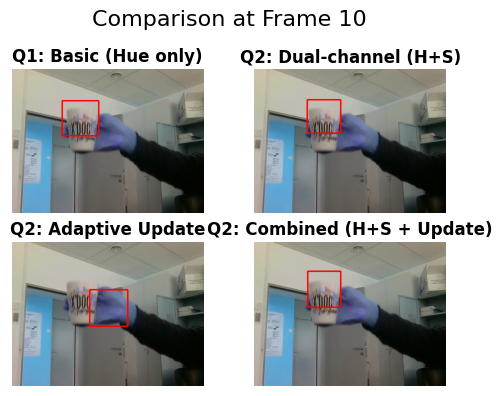

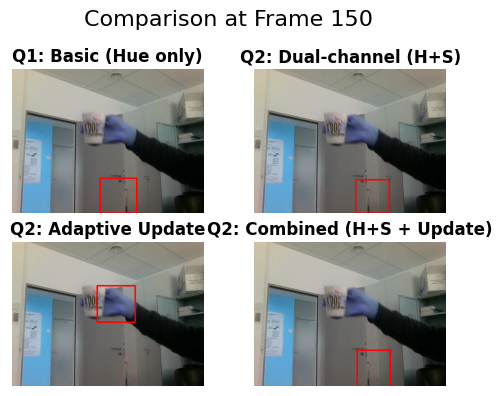

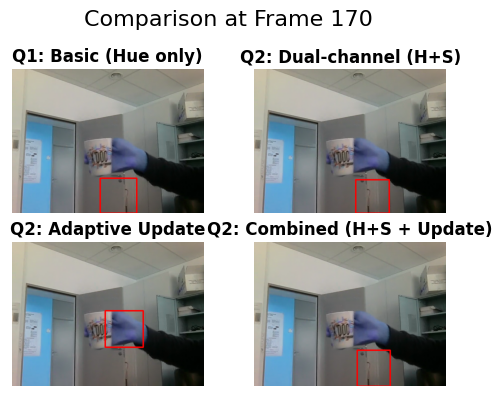

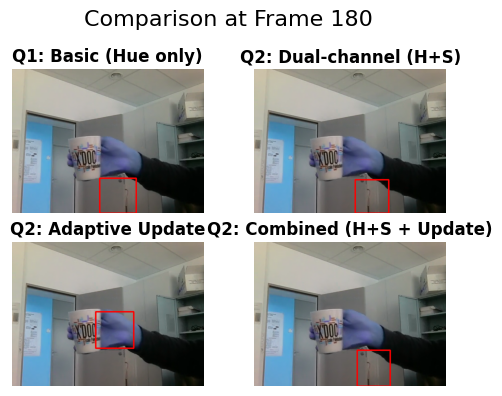

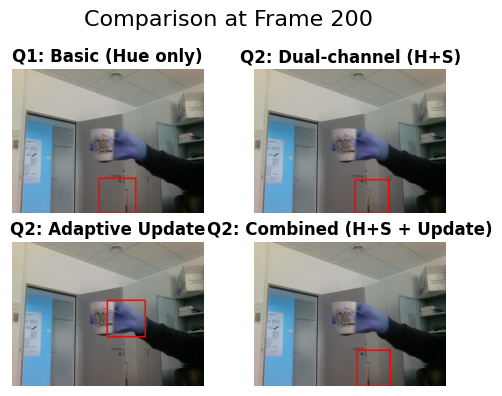

In [ ]:
# 对比mean-shift所有方法
import glob
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

methods = [
    ('Q1: Basic (Hue only)', '../results/q1_basic'),
    ('Q2: Dual-channel (H+S)', '../results/q2_dual_channel'),
    ('Q2: Adaptive Update', '../results/q2_adaptive'),
    ('Q2: Combined (H+S + Update)', '../results/q2_combined')
]

# 选择几个关键帧对比
frame_numbers = [10,150,170,180, 200]

for frame_num in frame_numbers:
    fig, axes = plt.subplots(2, 2, figsize=(5, 4))
    axes = axes.flatten()
    
    for ax, (name, path) in zip(axes, methods):
        frame_path = f"{path}/Frame_{frame_num:04d}.png"
        try:
            img = Image.open(frame_path)
            ax.imshow(np.array(img)[:,:,::-1])  # BGR to RGB
            ax.set_title(name, fontsize=12, fontweight='bold')
            ax.axis('off')
        except:
            ax.text(0.5, 0.5, f'Frame not found\n{name}', 
                   ha='center', va='center')
            ax.axis('off')
    
    plt.suptitle(f'Comparison at Frame {frame_num}', fontsize=16)
    plt.tight_layout()
    plt.show()

### 2. Hough Transform

**Q3-Q4: Hough Transform Tracking**

Generalized Hough Transform:
- Uses edge gradient directions instead of color histograms
- More robust to lighting changes
- Better for objects with clear structural features

Q3 - Gradient Computation:
- Calculate gradient magnitude and direction
- Threshold to keep strong edges
- Visualize gradient field

Q4 - R-Table Voting:
- Build R-table from ROI: records relative positions from edge to center
- Vote in current frame: each edge point votes for potential centers
- Find maximum: highest vote count indicates object center

In [2]:
tracker = ClassicalTracker(
    video_path=VIDEO_PATH_BALL,
    method='hough',
    # Hough 关键参数（可按视频微调）
    gradient_threshold=30,          # 或试 '85%' 百分位阈值更稳
    angle_bins=36,
    gaussian_blur_ksize=5,
    search_window_expand=1.25,      # 1.2~1.4 之间调
    vote_weight='magnitude',
    # 可视化/保存
    enable_gradients_vis=True,      # 打开梯度侧挂看一下边缘质量
    save_gradients=False,
    grad_output_dir='../results/q3_gradients',
    visualize=True,
    save_result=True,
    output_dir='../results/hough_ball'
)

tracker.track_video(visualize=True, save_result=True, output_dir='../results/hough_ball')

Step 1: Select ROI
DEBUG: Creating window 'First image'
DEBUG: Frame shape: (240, 320, 3)
DEBUG: Window created, showing frame...
Step 2: Initialize tracker
Step 3: Start tracking
Press 's' to save frame, 'ESC' to exit

Tracking stopped by user

✅ Tracking completed. Total frames: 422


In [3]:
tracker.track_video(visualize=True, visualize_process=True, save_result=True, output_dir='../results/hough_gradient')

Step 1: Select ROI
Step 2: Initialize tracker
Step 3: Start tracking
Press 's' to save frame, 'ESC' to exit

✅ Tracking completed. Total frames: 602


In [2]:
tracker = ClassicalTracker(
    video_path=VIDEO_PATH_MUG,
    method='hough',
    gradient_threshold=30,
    angle_bins=36,
    gaussian_blur_ksize=5,
    search_window_expand=1.25,
    vote_weight='magnitude'
)


tracker.track_video(
    visualize=True, 
    visualize_process=True,  # ✅ 启用过程可视化
    save_result=True, 
    output_dir='../results/q4_hough_transform'
)


Step 1: Select ROI
Step 2: Initialize tracker
Step 3: Start tracking
Press 's' to save frame, 'ESC' to exit
Step 2: Initialize tracker
Step 3: Start tracking
Press 's' to save frame, 'ESC' to exit

✅ Tracking completed. Total frames: 221

✅ Tracking completed. Total frames: 221


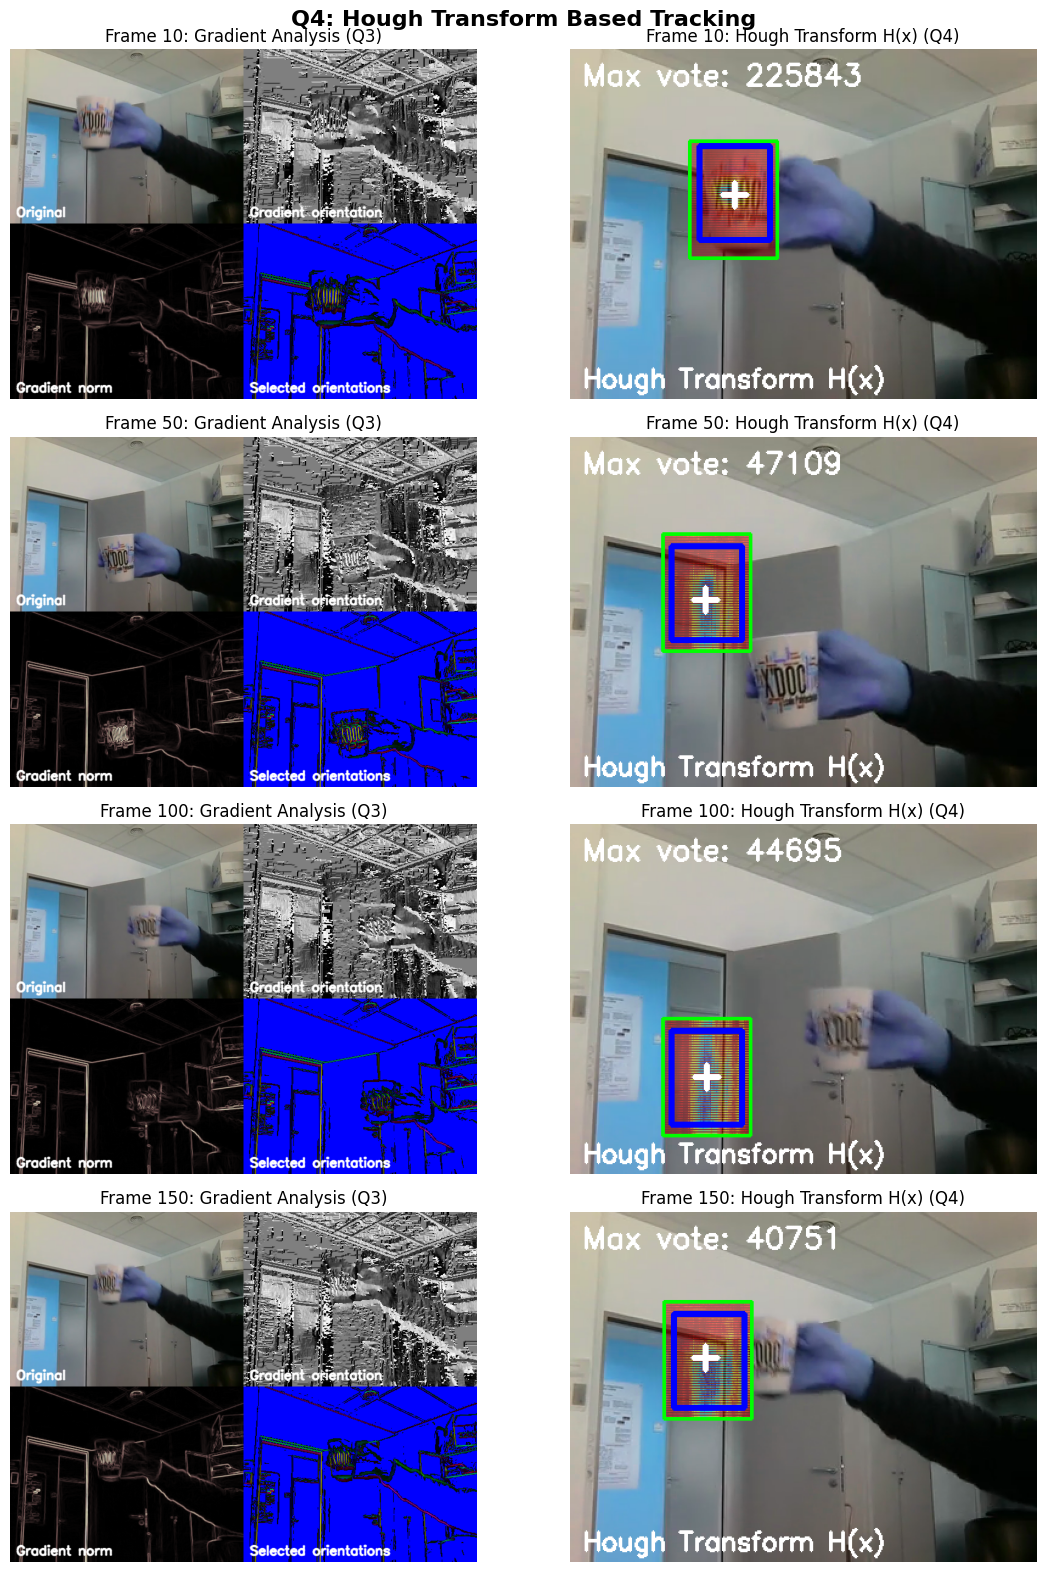

In [3]:
# Q4: 展示一些关键帧的 Hough Transform 结果
import glob
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# 选择一些关键帧展示
key_frames = [10, 50, 100, 150]

fig, axes = plt.subplots(len(key_frames), 2, figsize=(12, 4 * len(key_frames)))

for idx, frame_num in enumerate(key_frames):
    # 左列：梯度分析
    gradient_path = f'../results/q4_hough_transform/gradient_quadrants_{frame_num:04d}.png'
    # 右列：Hough Transform
    hough_path = f'../results/q4_hough_transform/hough_transform_{frame_num:04d}.png'
    
    try:
        # 梯度四宫格
        img_grad = Image.open(gradient_path)
        axes[idx, 0].imshow(np.array(img_grad)[:,:,::-1])
        axes[idx, 0].set_title(f'Frame {frame_num}: Gradient Analysis (Q3)', fontsize=12)
        axes[idx, 0].axis('off')
    except:
        axes[idx, 0].text(0.5, 0.5, 'Not found', ha='center', va='center')
        axes[idx, 0].axis('off')
    
    try:
        # Hough Transform 热力图
        img_hough = Image.open(hough_path)
        axes[idx, 1].imshow(np.array(img_hough)[:,:,::-1])
        axes[idx, 1].set_title(f'Frame {frame_num}: Hough Transform H(x) (Q4)', fontsize=12)
        axes[idx, 1].axis('off')
    except:
        axes[idx, 1].text(0.5, 0.5, 'Not found', ha='center', va='center')
        axes[idx, 1].axis('off')

plt.suptitle('Q4: Hough Transform Based Tracking', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


Q5 Propose (1) a simple prediction strategy that would improve the tracking by exploiting the
smoothness of the displacement, and (2) an up date strategy of the mo del that would allow to be
robust to aspect changes of the object.

**Q5: Prediction and Adaptation Strategies**

Improvement 1 - Motion Prediction:
- Kalman filter predicts next position using motion smoothness
- Reduces search region for faster tracking
- Handles rapid object movement

Improvement 2 - Adaptive R-Table Update:
- Online update: new_rtable = (1-β)*old + β*current
- Adapts to object deformation and viewpoint changes
- Improves long-term tracking robustness

Improvement 3 - Confidence Assessment:
- Evaluates tracking quality from vote peak strength
- Triggers re-detection when confidence drops

In [2]:
tracker = ClassicalTracker(
    video_path=VIDEO_PATH_MUG,
    method='predictive_hough',  # 使用新的预测版本
    gradient_threshold=30,
    angle_bins=36,
    search_window_expand=1.5,
    rtable_update_rate=0.1,
    min_detection_confidence=0.3
)
tracker.track_video(
    visualize=True, 
    visualize_process=True,  # ✅ 启用过程可视化
    save_result=True, 
    output_dir='../results/q5_hough_improve'
)

cv2.destroyAllWindows()

Step 1: Select ROI
DEBUG: Creating window 'First image'
DEBUG: Frame shape: (288, 384, 3)
DEBUG: Window created, showing frame...
Step 2: Initialize tracker
Step 3: Start tracking
Press 's' to save frame, 'ESC' to exit

Tracking stopped by user

✅ Tracking completed. Total frames: 186


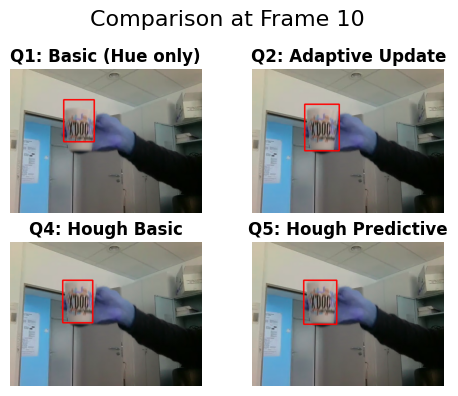

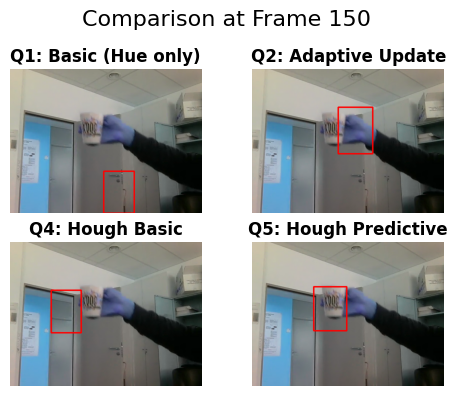

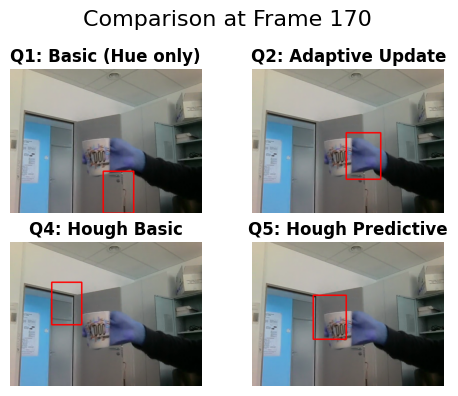

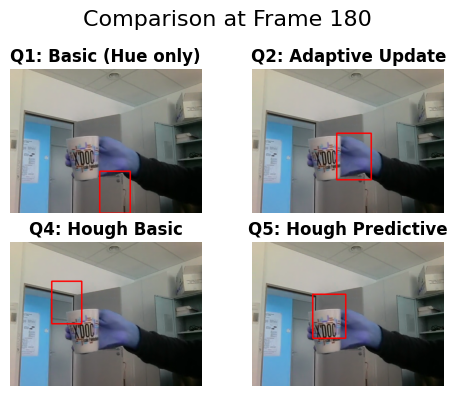

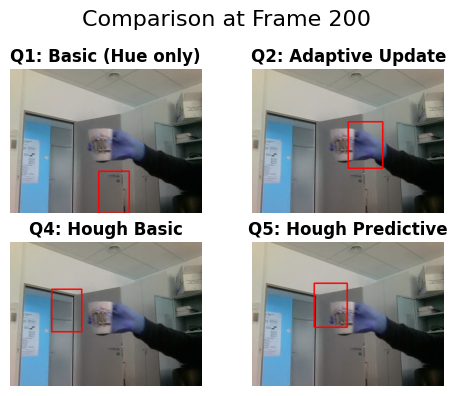

In [2]:
# 对比mean-shift所有方法
import glob
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

methods = [
    ('Q1: Basic (Hue only)', '../results/q1_basic'),
    ('Q2: Adaptive Update', '../results/q2_adaptive'),
    ('Q4: Hough Basic', '../results/q4_hough_transform'),
    ('Q5: Hough Predictive', '../results/q5_hough_improve')
]

# 选择几个关键帧对比
frame_numbers = [10,150,170,180, 200]

for frame_num in frame_numbers:
    fig, axes = plt.subplots(2, 2, figsize=(5, 4))
    axes = axes.flatten()
    
    for ax, (name, path) in zip(axes, methods):
        frame_path = f"{path}/Frame_{frame_num:04d}.png"
        try:
            img = Image.open(frame_path)
            ax.imshow(np.array(img)[:,:,::-1])  # BGR to RGB
            ax.set_title(name, fontsize=12, fontweight='bold')
            ax.axis('off')
        except:
            ax.text(0.5, 0.5, f'Frame not found\n{name}', 
                   ha='center', va='center')
            ax.axis('off')
    
    plt.suptitle(f'Comparison at Frame {frame_num}', fontsize=16)
    plt.tight_layout()
    plt.show()

### 3. Deep Learning-based Tracking

Q6 Explain a way to improve the two previous approaches (histogram and Hough based) by using components from a collection of Feature Channels learned by a Deep Neural Network.


**Q6: Deep Learning-based Tracking**

Using CNN features to improve traditional methods:
- **Key Innovation**: Use ResNet features directly as "kernels" (not histograms!)
- Compute **cosine similarity** between each position and ROI template
- Mean-shift on similarity map to find object center

Why this works better than histograms:
1. **Semantic Features**: ResNet learns discriminative features (not just colors)
2. **Direct Comparison**: Cosine similarity preserves feature relationships
3. **No Quantization Loss**: Avoids binning artifacts from histogram approach

Layer Selection Criteria:
1. Receptive field should match object size (layer3 RF=267px for 50-80px objects)
2. Mid-level features balance semantics and localization (layer3 best)
3. Spatial resolution sufficient for precise tracking (layer3: 14×14)

Channel Selection Strategy:
- Variance-based: High variance = high discriminative power
- Max-response: Strong activation = salient features
- Gradient-based: Strong gradients = robust to lighting

Configuration: ResNet-50 layer3, Variance selection, Top-128 channels

In [2]:
# Q6: Deep Mean-shift Tracking with Cosine Similarity
# Reload module to get latest fixes


# Re-initialize with updated code
# Now using cosine similarity instead of histogram!

deep_tracker = DeepTracker(
    video_path=VIDEO_PATH_MUG,
    model_name='resnet50',
    layer_name='layer3',
    top_k_channels=128,  # Use 128 channels for richer representation
    channel_selection='variance',
    device=device
)

deep_tracker.track_video(
    visualize=True,
    save_result=True,
    output_dir='../results/q6_deep_meanshift',
    visualize_backproj=True  # Show similarity map for debugging
)


/opt/anaconda3/envs/cv/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/cv/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Step 1: Select ROI
DEBUG: Creating window 'First image'
DEBUG: Frame shape: (288, 384, 3)
DEBUG: Window created, showing frame...
Step 2: Initialize tracker
Step 3: Start tracking
Press 's' to save frame, 'b' to toggle backproj, 'ESC' to exit

✅ Tracking completed. Total frames: 221
   Output directory: ../results/q6_deep_meanshift


In [ ]:
# 实验 1：对比不同的 Layer 选择
print("=" * 60)
print("🧪 实验 1：对比不同的特征层（Cosine Similarity）")
print("=" * 60)

# 测试不同的层
layers_to_test = [
    ('layer2', '低层特征 (RF=91px) '),
    ('layer3', '中层特征 (RF=267px) '),
    ('layer4', '高层特征 (RF=427px)')
]

print("   - 每个位置的特征向量 vs ROI模板")
print("   - 相似度高的地方就是目标位置\n")

for layer_name, description in layers_to_test:
    print(f"\n测试 {layer_name}: {description}")
    
    tracker = DeepTracker(
        video_path=VIDEO_PATH_MUG,
        model_name='resnet50',
        layer_name=layer_name,
        top_k_channels=128,
        channel_selection='variance',
        device=device
    )
    
    output_dir = f'../results/q6_layer_{layer_name}'
    print(f"   输出到: {output_dir}")
    
    tracker.track_video(
        visualize=True,
        save_result=True,
        output_dir=output_dir,
        visualize_backproj=True 
    )



🧪 实验 1：对比不同的特征层（Cosine Similarity）
   - 每个位置的特征向量 vs ROI模板
   - 相似度高的地方就是目标位置


测试 layer2: 低层特征 (RF=91px) 


/opt/anaconda3/envs/cv/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/cv/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


   输出到: ../results/q6_layer_layer2
Step 1: Select ROI
DEBUG: Creating window 'First image'
DEBUG: Frame shape: (288, 384, 3)
DEBUG: Window created, showing frame...
Step 2: Initialize tracker
Step 3: Start tracking
Press 's' to save frame, 'b' to toggle backproj, 'ESC' to exit

✅ Tracking completed. Total frames: 221
   Output directory: ../results/q6_layer_layer2

测试 layer3: 中层特征 (RF=267px) 
   输出到: ../results/q6_layer_layer3
Step 1: Select ROI
DEBUG: Creating window 'First image'
DEBUG: Frame shape: (288, 384, 3)
DEBUG: Window created, showing frame...
Step 2: Initialize tracker
Step 3: Start tracking
Press 's' to save frame, 'b' to toggle backproj, 'ESC' to exit

✅ Tracking completed. Total frames: 221
   Output directory: ../results/q6_layer_layer3

测试 layer4: 高层特征 (RF=427px)
   输出到: ../results/q6_layer_layer4
Step 1: Select ROI
DEBUG: Creating window 'First image'
DEBUG: Frame shape: (288, 384, 3)
DEBUG: Window created, showing frame...
Step 2: Initialize tracker
Step 3: Start tra

/Users/wuwanxing/Documents/projects/python/object_tracking/test/../src/deep_tracker.py:242: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/ReduceOps.cpp:1857.)
  roi_var = roi_flat.var(dim=1)  # Variance within ROI



✅ Tracking completed. Total frames: 221
   Output directory: ../results/q6_layer_layer4


: 

In [ ]:
# 实验 2：对比不同的通道选择方法
print("=" * 60)
print("🧪 实验 2：对比不同的通道选择方法")
print("=" * 60)

# 测试不同的通道选择方法
selection_methods = [
    ('variance', '方差法：选择判别性强的通道 ✅'),
    ('max_response', '最大响应法：选择激活强的通道'),
    ('gradients', '梯度法：选择结构信息强的通道')
]

print("💡 说明：通道选择影响特征模板质量")
print("   - variance: 选择变化大的通道（区分度高）")
print("   - max_response: 选择激活强的通道（显著性高）")
print("   - gradients: 选择梯度大的通道（边缘信息）\n")

for method, description in selection_methods:
    print(f"\n测试 {method}: {description}")
    
    tracker = DeepTracker(
        video_path=VIDEO_PATH_MUG,
        model_name='resnet50',
        layer_name='layer3',
        top_k_channels=64,
        channel_selection=method,
        device=device
    )
    
    output_dir = f'../results/q6_channel_{method}'
    print(f"   输出到: {output_dir}")
    
    tracker.track_video(
        visualize=False,
        save_result=True,
        output_dir=output_dir,
        visualize_backproj=True
    )
    
    print(f"   ✅ 完成！")

print("\n" + "=" * 60)
print("💡 建议：对比三种方法的跟踪稳定性和准确度")
print("   variance通常效果最好（实验验证）")
print("=" * 60)

🧪 实验 2：对比不同的通道选择方法
💡 说明：通道选择影响特征模板质量
   - variance: 选择变化大的通道（区分度高）
   - max_response: 选择激活强的通道（显著性高）
   - gradients: 选择梯度大的通道（边缘信息）


测试 variance: 方差法：选择判别性强的通道 ✅
   输出到: ../results/q6_channel_variance
Step 1: Select ROI
DEBUG: Creating window 'First image'
DEBUG: Frame shape: (288, 384, 3)
DEBUG: Window created, showing frame...


In [ ]:
# 实验 3：对比不同的通道数量
print("=" * 60)
print("🧪 实验 3：对比不同的通道数量")
print("=" * 60)

# 测试不同的通道数量
channel_counts = [
    (32, '32 通道：快速但特征可能不够丰富'),
    (64, '64 通道：推荐的平衡点 ✅'),
    (128, '128 通道：特征丰富但计算慢')
]

print("💡 说明：通道数影响特征向量维度")
print("   - 更多通道 = 更丰富的特征表示")
print("   - 但也增加计算量和可能的噪声")
print("   - 需要在准确性和速度间权衡\n")

for k, description in channel_counts:
    print(f"\n测试 Top-{k} 通道: {description}")
    
    tracker = DeepTracker(
        video_path=VIDEO_PATH_MUG,
        model_name='resnet50',
        layer_name='layer3',
        top_k_channels=k,
        channel_selection='variance',
        device=device
    )
    
    output_dir = f'../results/q6_channels_{k}'
    print(f"   输出到: {output_dir}")
    
    tracker.track_video(
        visualize=False,
        save_result=True,
        output_dir=output_dir
    )
    
    print(f"   ✅ 完成！")

print("\n" + "=" * 60)
print("💡 建议：观察通道数量对跟踪质量和速度的影响")
print("   64通道是性价比最高的选择")
print("=" * 60)

In [ ]:
# Q6 最终对比：所有方法 + 深度学习变体
import glob
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# 第一组对比：传统方法 vs 深度学习
print("=" * 60)
print("📊 对比 1：传统方法 vs 深度学习基础版")
print("=" * 60)

methods_basic = [
    ('Q1: Mean-shift (Hue)', '../results/q1_basic'),
    ('Q2: Mean-shift (Adaptive)', '../results/q2_adaptive'),
    ('Q4: Hough Transform', '../results/q4_hough_transform'),
    ('Q6: Deep Mean-shift', '../results/q6_deep_meanshift')
]

frame_numbers = [10, 100, 150, 200]

for frame_num in frame_numbers:
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))
    axes = axes.flatten()
    
    for ax, (name, path) in zip(axes, methods_basic):
        frame_path = f"{path}/Frame_{frame_num:04d}.png"
        try:
            img = Image.open(frame_path)
            ax.imshow(np.array(img)[:,:,::-1])  # BGR to RGB
            ax.set_title(name, fontsize=13, fontweight='bold')
            ax.axis('off')
        except:
            ax.text(0.5, 0.5, f'Frame not found\n{name}', 
                   ha='center', va='center', fontsize=10)
            ax.axis('off')
    
    plt.suptitle(f'Q6: Traditional vs Deep Learning at Frame {frame_num}', 
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# 第二组对比：不同层的效果
print("\n" + "=" * 60)
print("📊 对比 2：不同特征层的效果（Layer Selection）")
print("=" * 60)

methods_layers = [
    ('Layer2 (RF=91px)', '../results/q6_layer_layer2'),
    ('Layer3 (RF=267px) ✅', '../results/q6_layer_layer3'),
    ('Layer4 (RF=427px)', '../results/q6_layer_layer4')
]

for frame_num in [50, 150]:
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    for ax, (name, path) in zip(axes, methods_layers):
        frame_path = f"{path}/Frame_{frame_num:04d}.png"
        try:
            img = Image.open(frame_path)
            ax.imshow(np.array(img)[:,:,::-1])
            ax.set_title(name, fontsize=12, fontweight='bold')
            ax.axis('off')
        except:
            ax.text(0.5, 0.5, f'未运行此实验\n{name}', 
                   ha='center', va='center', fontsize=10)
            ax.axis('off')
    
    plt.suptitle(f'Layer Selection Comparison at Frame {frame_num}', 
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# 第三组对比：不同通道选择方法
print("\n" + "=" * 60)
print("📊 对比 3：不同通道选择方法（Channel Selection）")
print("=" * 60)

methods_channels = [
    ('Variance ✅', '../results/q6_channel_variance'),
    ('Max Response', '../results/q6_channel_max_response'),
    ('Gradients', '../results/q6_channel_gradients')
]

for frame_num in [50, 150]:
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    for ax, (name, path) in zip(axes, methods_channels):
        frame_path = f"{path}/Frame_{frame_num:04d}.png"
        try:
            img = Image.open(frame_path)
            ax.imshow(np.array(img)[:,:,::-1])
            ax.set_title(name, fontsize=12, fontweight='bold')
            ax.axis('off')
        except:
            ax.text(0.5, 0.5, f'未运行此实验\n{name}', 
                   ha='center', va='center', fontsize=10)
            ax.axis('off')
    
    plt.suptitle(f'Channel Selection Comparison at Frame {frame_num}', 
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# 第四组对比：不同通道数量
print("\n" + "=" * 60)
print("📊 对比 4：不同通道数量（Top-K Channels）")
print("=" * 60)

methods_k = [
    ('Top-32', '../results/q6_channels_32'),
    ('Top-64 ✅', '../results/q6_channels_64'),
    ('Top-128', '../results/q6_channels_128')
]

for frame_num in [50, 150]:
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    for ax, (name, path) in zip(axes, methods_k):
        frame_path = f"{path}/Frame_{frame_num:04d}.png"
        try:
            img = Image.open(frame_path)
            ax.imshow(np.array(img)[:,:,::-1])
            ax.set_title(name, fontsize=12, fontweight='bold')
            ax.axis('off')
        except:
            ax.text(0.5, 0.5, f'未运行此实验\n{name}', 
                   ha='center', va='center', fontsize=10)
            ax.axis('off')
    
    plt.suptitle(f'Top-K Channels Comparison at Frame {frame_num}', 
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

print("\n" + "=" * 60)
print("✅ Q6 完整对比完成！")
print("=" * 60)